In [1]:
import os, sys, time
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
# Create timestamp to show when this summary was run
print('Summary run: ' + time.strftime("%a, %d %b %Y %H:%M"))

Summary run: Fri, 09 Apr 2021 10:31


In [3]:
base_path = os.getcwd().split('\\scripts')[0]
relative_path = '../../../outputs'
pd.options.display.float_format = '{:,.3f}'.format
format_percent = "{:,.2%}".format

# Workers by County

In [4]:
df_wfh = pd.read_csv(os.path.join(relative_path,'agg','dash','wfh_county.csv'))
df_wfh_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','wfh_county.csv'))

# Total Workers by County
df_tot = pd.read_csv(os.path.join(relative_path,'agg','dash','pptyp_county.csv'))
df_tot = df_tot[df_tot['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot = df_tot.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers = df_tot.sum()['psexpfac']

df_tot_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','pptyp_county.csv'))
df_tot_survey = df_tot_survey[df_tot_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_tot_survey = df_tot_survey.groupby('person_county').sum()[['psexpfac']].reset_index()
total_nonwfh_workers_survey = df_tot_survey.sum()['psexpfac']

df = df_wfh.merge(df_tot, on='person_county')
df.index = df['person_county']
df.drop('person_county', axis=1,inplace=True)
df.columns = ['WFH Workers', 'Total Workers']
df.loc['Region'] = df.sum(axis=0)
df['% WFH Workers'] = df['WFH Workers']/df['Total Workers']
df

,WFH Workers,Total Workers,% WFH Workers
person_county,,,
King,"61,663.000","757,936.000",0.081
Kitsap,"11,213.000","185,105.000",0.061
Pierce,"30,720.000","466,723.000",0.066
Snohomish,"27,545.000","469,048.000",0.059
Region,"131,141.000","1,878,812.000",0.070


In [5]:
df_tot.sum()['psexpfac']

1878812.0

# Tour Rate for Work-at-Home Workers

In [6]:
df_tours = pd.read_csv(os.path.join(relative_path,'agg','dash','work_from_home_tours.csv'))
total_wfh_workers = df_wfh.psexpfac.sum()
df = df_tours.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df['tour_rate'] = df['toexpfac']/total_wfh_workers
df

df_tours_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','work_from_home_tours.csv'))
total_wfh_workers_survey = df_wfh.psexpfac.sum()
df_survey = df_tours_survey.groupby('pdpurp').sum()[['toexpfac']].reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/total_wfh_workers_survey
df = df.merge(df_survey,on='pdpurp',suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model': 'tours_model', 'toexpfac_survey': 'tours_survey'}, inplace=True)
df['tours_survey'] = df['tours_survey'].astype('int')
df[['pdpurp','tours_model','tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,tours_model,tours_survey,tour_rate_model,tour_rate_survey
0,Escort,"47,323.000",23855,0.361,0.182
1,Meal,"6,494.000",13883,0.050,0.106
2,Personal Business,"32,536.000",37346,0.248,0.285
3,School,"3,681.000",687,0.028,0.005
4,Shop,"40,290.000",51688,0.307,0.394
5,Social,"40,089.000",76994,0.306,0.587
6,Work,"19,058.000",25335,0.145,0.193


### Tour Rates for Workers that do NOT WF

In [7]:
# Tour Rates by purpose by worker type
df = pd.read_csv(os.path.join(relative_path,'agg','dash','non_wfh_tours.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot.sum()[['psexpfac']].values[0]

df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','non_wfh_tours.csv'))
df_survey = df_survey[df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,"210,709.000","174,142.860",0.112,0.093
1,Meal,"343,054.000","239,951.960",0.183,0.129
2,Personal Business,"176,329.000","269,848.570",0.094,0.145
3,School,"26,633.000","15,975.350",0.014,0.009
4,Shop,"236,746.000","249,110.000",0.126,0.134
5,Social,"478,233.000","454,542.440",0.255,0.244
6,Work,"1,632,513.000","1,903,085.920",0.869,1.020


In [8]:
total_nonwfh_workers

1878812.0

### Tour Rates for Non-Workers

In [9]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','non_wfh_tours.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df = df.groupby('pdpurp').sum().reset_index()
df['tour_rate'] = df['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]


df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','non_wfh_tours.csv'))
df_survey = df_survey[-df_survey['pptyp'].isin(['Full-Time Worker', 'Part-Time Worker'])]
df_survey = df_survey.groupby('pdpurp').sum().reset_index()
df_survey['tour_rate'] = df_survey['toexpfac']/df_tot_survey.sum()[['psexpfac']].values[0]

df = df.merge(df_survey, on='pdpurp', suffixes=['_model','_survey'])
df.rename(columns={'toexpfac_model':'total_tours_model','toexpfac_survey':'total_tours_survey'},
         inplace=True)
df[['pdpurp','total_tours_model','total_tours_survey','tour_rate_model','tour_rate_survey']]

,pdpurp,total_tours_model,total_tours_survey,tour_rate_model,tour_rate_survey
0,Escort,"491,798.000","430,403.590",0.264,0.231
1,Meal,"126,995.000","166,557.020",0.068,0.089
2,Personal Business,"528,945.000","605,619.500",0.284,0.325
3,School,"661,027.000","702,028.230",0.354,0.376
4,Shop,"505,963.000","492,264.740",0.271,0.264
5,Social,"737,458.000","742,332.310",0.395,0.398
6,Work,"81,170.000","131,466.770",0.044,0.070


# Commute Tour Distance
All Workers

In [10]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']

pd.options.display.float_format = '{:0,.4f}'.format
_df = df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
_df['cumulative_percent'] = _df['percent'].cumsum()

# remove records that are outside 99% of records
_df = _df[_df['cumulative_percent'] <= 0.99]

In [11]:
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','tour_distance.csv'))
df_survey = df_survey[df_survey['pdpurp'] == 'Work']

_df_survey = df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

_df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
_df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

# remove records that are outside 99% of records
_df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

Weighted Average Distance

In [12]:
if len(_df_survey) > 0:
    _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
    print('model: '+ str((_df_merged['toexpfac_model']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_model'].sum()))
    print('survey: '+ str((_df_merged['toexpfac_survey']*_df_merged['tautodist_bin']).sum()*1.0/_df_merged['toexpfac_survey'].sum()))
else:
    print(str((_df['toexpfac']*_df['tautodist_bin']).sum()*1.0/_df['toexpfac'].sum()))


10.15306173649124


In [13]:
# Work trip distance to not usual workplace for non-WFH workers


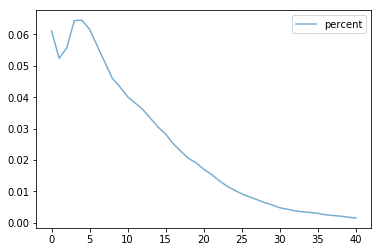

In [14]:
if len(_df_survey) > 0:
    _df_merged[['percent_model','percent_survey']].plot(alpha=0.6)
else:
    _df[['percent']].plot(alpha=0.6)

# Average Trip Distance
Workers that work DO NOT work from home

In [15]:
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df = df[df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]
# df.groupby(['travdist_bin','']).sum()[['trexpfac']]
df_usual = df[df['dadtyp'] == 'Usual Workplace']
dist = (df_usual['trexpfac']*1.0*df_usual['travdist_bin']).sum()/df_usual['trexpfac'].sum()
print('Avg. distance to Usual Workplace: ' + str(dist))
df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------------')
# Non WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_wfh = pd.DataFrame.from_dict(result, orient='index').reset_index()
_df_non_wfh.columns = ['Purpose','Workers at Non-Home Location']
_df_non_wfh

Avg. distance to Usual Workplace: 8.386589409100386
Avg. distance to Other Workplace: 4.664319652850579
----------------------------------------


,Purpose,Workers at Non-Home Location
0,None/Home,5.3108
1,Work,7.6215
2,School,3.0791
3,Escort,5.2399
4,Personal Business,4.4097
5,Shop,3.6469
6,Meal,2.7441
7,Social,3.8445
8,Change Mode Inserted Purpose,7.9084


Only workers that work **from home**

In [16]:
# WFH Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_wfh.csv'))
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

df_other = df[df['dadtyp'] == 'Other']
dist = (df_other['trexpfac']*1.0*df_other['travdist_bin']).sum()/df_other['trexpfac'].sum()
print('Avg. distance to Other Workplace: ' + str(dist))
print('----------------------------------')
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()

_df_wfh = pd.DataFrame.from_dict(result, orient='index')
_df_wfh = _df_wfh.reset_index()
_df_wfh.columns = ['Purpose','WFH Workers']
_df_wfh

Avg. distance to Other Workplace: 4.27466013278533
----------------------------------


,Purpose,WFH Workers
0,None/Home,2.5301
1,Work,4.2724
2,School,4.6389
3,Escort,2.4480
4,Personal Business,1.9350
5,Shop,1.9392
6,Meal,1.7694
7,Social,1.9750
8,Change Mode Inserted Purpose,4.6828


In [17]:
# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df = df[-df['pptyp'].isin(['Full-Time Worker','Part-Time Worker'])]
df = df[(df['dpurp'] == 'Work') & (df['dadtyp'].isin(['Other','Usual Workplace']))]

# Non-Workers
df = pd.read_csv(os.path.join(relative_path,'agg','dash','trip_distance_non_wfh.csv'))
df['wt_sum'] = df['trexpfac']*1.0*df['travdist_bin']
result = {}
for purp in pd.unique(df['dpurp']):
    _df = df[df['dpurp'] == purp]
    result[purp] = _df['wt_sum'].sum()/_df['trexpfac'].sum()
    
_df_non_worker = pd.DataFrame.from_dict(result, orient='index')
_df_non_worker = _df_non_worker.reset_index()
_df_non_worker.columns = ['Purpose','Non-Workers']
_df_non_worker

,Purpose,Non-Workers
0,None/Home,5.3108
1,Work,7.6215
2,School,3.0791
3,Escort,5.2399
4,Personal Business,4.4097
5,Shop,3.6469
6,Meal,2.7441
7,Social,3.8445
8,Change Mode Inserted Purpose,7.9084


Average Trip Distance by Purpose and Worker/Person Type

In [18]:
_df = pd.merge(_df_non_wfh, _df_wfh).merge(_df_non_worker)

In [19]:
_df

,Purpose,Workers at Non-Home Location,WFH Workers,Non-Workers
0,None/Home,5.3108,2.5301,5.3108
1,Work,7.6215,4.2724,7.6215
2,School,3.0791,4.6389,3.0791
3,Escort,5.2399,2.4480,5.2399
4,Personal Business,4.4097,1.9350,4.4097
5,Shop,3.6469,1.9392,3.6469
6,Meal,2.7441,1.7694,2.7441
7,Social,3.8445,1.9750,3.8445
8,Change Mode Inserted Purpose,7.9084,4.6828,7.9084


# VMT

Workers that Work from Home

In [20]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','vmt_wfh.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','vmt_wfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_wfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_wfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,164,0.00,-1320,-0.01
Escort,131028,1.00,-18998,-0.14
Meal,22014,0.17,-12122,-0.09
None/Home,363176,2.77,-82089,-0.63
Personal Business,121492,0.93,-26755,-0.20
School,4277,0.03,-120,-0.00
Shop,139619,1.06,-89591,-0.68
Social,82645,0.63,-26746,-0.20
Work,13242,0.10,-3706,-0.03


Workers that do NOT Work from Home

In [21]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','vmt_nonwfh.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','vmt_nonwfh.csv'))

pd.options.display.float_format = '{:,.2f}'.format
_df = df[(df['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df['dorp']==1) &
   (df['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df['VMT per Person (Model)'] = _df['travdist_wt']/total_nonwfh_workers

_df_survey = df_survey[(df_survey['mode'].isin(['SOV','HOV2','HOV3+']))&
   (df_survey['dorp']==1) &
   (df_survey['pptyp'].isin(['Full-Time Worker','Part-Time Worker']))].groupby('dpurp').sum()[['travdist_wt']]
_df_survey['VMT per Person (Model)'] = _df_survey['travdist_wt']/total_nonwfh_workers_survey

_df = _df.merge(_df_survey, left_index=True, right_index=True, suffixes=['_model','_survey'])
_df.loc['Total',:] = _df.sum()
_df[['travdist_wt_model','travdist_wt_survey']] = _df[['travdist_wt_model','travdist_wt_survey']].astype('int')
_df.rename(columns={'travdist_wt_model': 'Total VMT (Model)', 'travidst_wt_survey': 'Total VMT (Survey)'},
                   inplace=True)
_df

,Total VMT (Model),VMT per Person (Model)_model,travdist_wt_survey,VMT per Person (Model)_survey
dpurp,,,,
Change Mode Inserted Purpose,255885,0.14,-11606,-0.01
Escort,2691903,1.43,-611606,-0.33
Meal,1252742,0.67,-415146,-0.22
None/Home,15905151,8.47,-2225642,-1.19
Personal Business,1989691,1.06,-604545,-0.32
School,185972,0.10,-14149,-0.01
Shop,2293624,1.22,-702148,-0.38
Social,2354854,1.25,-495702,-0.27
Work,16456391,8.76,-2224998,-1.19


# Commute Tour Distance by Mode
All Workers

In [22]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','tour_distance.csv'))
df.groupby('tmodetp').size()

tmodetp
Bike           939
HOV2          2368
HOV3+         2432
Park           211
SOV           1871
School Bus     156
TNC            579
Transit       1373
Walk           480
dtype: int64

Walk
Bike
SOV
HOV2
HOV3+
Transit
Park


TNC


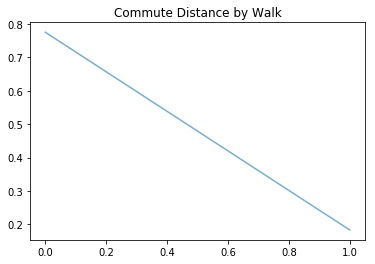

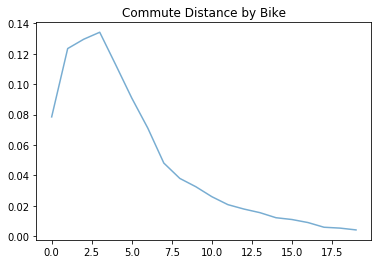

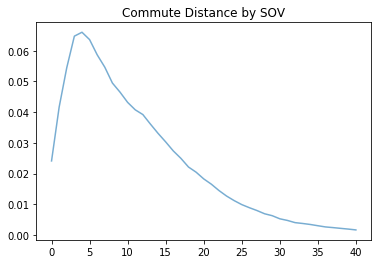

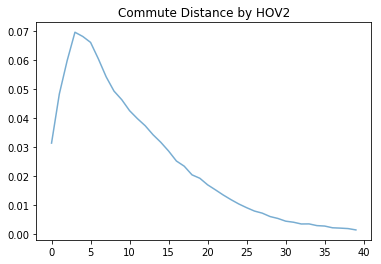

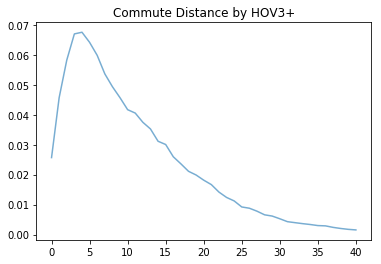

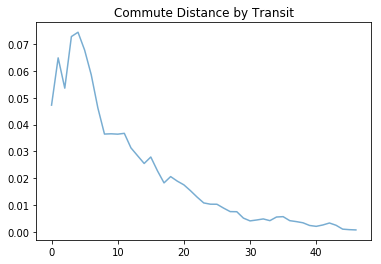

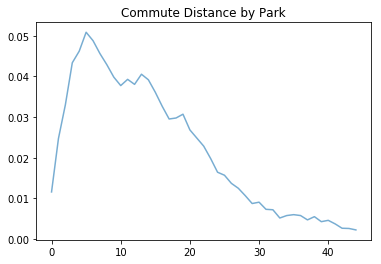

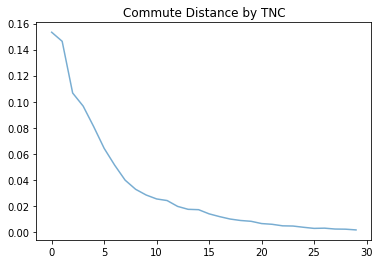

In [23]:
df = pd.read_csv(os.path.join(relative_path,'agg','dash','tour_distance.csv'))
df_survey = pd.read_csv(os.path.join(relative_path,'agg','dash','survey','tour_distance.csv'))
df = df[df['pdpurp'] == 'Work']
df = df[df['tmodetp'] != "-1"]

for mode in df['tmodetp'].unique():
    _df = df[df['tmodetp'] == mode]
    
    
    if len(_df) > 0:
        print(mode)
        _df = _df.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

        _df['percent'] = _df['toexpfac']/_df['toexpfac'].sum()
        _df['cumulative_percent'] = _df['percent'].cumsum()

        # remove records that are outside 99% of records
        _df = _df[_df['cumulative_percent'] <= 0.99]

        _df_survey = df_survey[df_survey['tmodetp'] == mode]
        _df_survey = _df_survey.groupby('tautodist_bin').sum()[['toexpfac']].reset_index()

        _df_survey['percent'] = _df_survey['toexpfac']/_df_survey['toexpfac'].sum()
        _df_survey['cumulative_percent'] = _df_survey['percent'].cumsum()

        # remove records that are outside 99% of records
        _df_survey = _df_survey[_df_survey['cumulative_percent'] <= 0.99]

        fig, ax = plt.subplots()
        if len(_df_survey > 0):
            _df_merged = _df.merge(_df_survey, on='tautodist_bin', suffixes=['_model','_survey'])
            _df_merged[['percent_model','percent_survey']].plot(alpha=0.6, title=mode)
        else:
            _df['percent'].plot(alpha=0.6, title='Commute Distance by '+str(mode))
        

